## Import Packages

In [1]:
# API Requests for data
import requests

# Data Manipulation and Analysis
import pandas as pd
from pprint import pprint 
import json
from io import StringIO
import numpy as np

# Database Connection
from sqlalchemy import create_engine

# SQL Querying
from sqlalchemy import inspect, text

#  Plotting and Visualization
from plotnine import *
from plotnine.scales import scale_x_date
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
from plotnine.exceptions import PlotnineWarning


# Regressions and Statistics
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# File and System Operations
import os
import sys

## Other Setup

In [2]:
pd.set_option('display.max_columns', None) # Display all columns in any given DataFrame

### Import Custom Packages

In [3]:
# Change the wd
sys.path.insert(0,'../src/')

#Import the packages
from macro_utils import sql_queries as sqlq
from macro_utils import functions as macro

## Data Setup and Import

### Load in the Data from the BLS

In [4]:
# Read in the CPI data
cpi=pd.read_excel('../data/cpi_by_item.xlsx')




In [5]:
# Read in the CPI weights data
cpi_weights = pd.read_excel('../data/cpi_weights.xlsx', header=7)

## Data Cleaning

### Change the Column Names

In [6]:
# convert all columns to lowercase with underscore format
cpi.columns = cpi.columns.str.lower().str.replace(' ', '_')

# convert all the x-month_%_change columns to x_month_pct_change for x in 1,3,6,12
for x in [1, 3, 6, 12]:
    cpi.columns = cpi.columns.str.replace(f'{x}-month_%_change', f'{x}_month_pct_change')

# create an inverse mapping of these column names back to the original, names
inverse_col_map = {v: k for k, v in zip(cpi.columns, cpi.columns.str.replace('_', ' ').str.title())}

cpi.head()


,series_id,year,period,label,value,1_month_pct_change,3_month_pct_change,6_month_pct_change,12_month_pct_change
0,CUUR0000SA0,2015,M01,2015 Jan,233.707,-0.5,-1.6,-1.9,-0.1
1,CUUR0000SA0,2015,M02,2015 Feb,234.722,0.4,-0.6,-1.3,0.0
2,CUUR0000SA0,2015,M03,2015 Mar,236.119,0.6,0.6,-0.8,-0.1
3,CUUR0000SA0,2015,M04,2015 Apr,236.599,0.2,1.2,-0.4,-0.2
4,CUUR0000SA0,2015,M05,2015 May,237.805,0.5,1.3,0.7,0.0


### Add new Columns

In [7]:
# Add A column for the Actual Name of the Series
# Manual mapping of series_id to full names
series_name_map = {
    'CUUR0000SA0': 'U.S. city average All Items Not Seasonally Adjusted',
    'CUUS0000SAA': 'U.S. city average Apparel Not Seasonally Adjusted',
    'CCUUS0000SETA02': 'U.S. city average Used cars and trucks Not Seasonally Adjusted',
    'CUUR0000SERE01': 'U.S. city average Toys Not Seasonally Adjusted',
    'CUUR0000SA0L1E' : 'U.S. city average All Items Less Food and Energy Not Seasonally Adjusted',
    'CUURN000SAH3': 'U.S. city average Housing Not Seasonally Adjusted'

}

# Map full name
cpi['series_full_name'] = cpi['series_id'].map(series_name_map)

# Extract short name (last part before "Not Seasonally Adjusted")
cpi['series_short_name'] = cpi['series_full_name'].str.extract(r'U\.S\. city average (.*?) Not Seasonally Adjusted')

# Add a column for data
# Only keep rows where period matches 'M01' to 'M12' (the others are seasons)
cpi = cpi[cpi['period'].str.match(r'^M(0[1-9]|1[0-2])$')].copy()

# Combine year and period to create a YYYY-MM string, then convert to datetime (end of month)
cpi['date'] = pd.to_datetime(
    cpi['year'].astype(str) + '-' + cpi['period'].str.replace('M', ''), 
    format='%Y-%m'
) + pd.offsets.MonthEnd(0)


# Move columns for readability
start_cols = ['series_id', 'series_short_name', 'date', 'series_full_name', 'value']
cpi = cpi[start_cols + [col for col in cpi.columns if col not in start_cols]]

### Clean the CPI Weights Data

In [8]:
# Remove the furst and last columns from cpi_weights
cpi_weights = cpi_weights.iloc[:, 1:-1]

# rename what is now the second column as 'weight'
cpi_weights.rename(columns={cpi_weights.columns[1]: 'weight'}, inplace=True)

# convert the weight column into proportions by dividing by 100
cpi_weights['weight'] = cpi_weights['weight'] / 100

#rename expenditure catgory to 'series_short_name'
cpi_weights.rename(columns={cpi_weights.columns[0]: 'series_short_name'}, inplace=True)

# remove the first row, which is empty
cpi_weights = cpi_weights.iloc[1:, :].reset_index(drop=True)

# Remove any whitespace at the start or end of the series_short_name
cpi_weights['series_short_name'] = cpi_weights['series_short_name'].str.strip()
# convert the series_short_name to title case
cpi_weights['series_short_name'] = cpi_weights['series_short_name'].str.title()
# convert 'and', 'the', 'of', 'in', 'to', 'for', 'with' to lowercase (except if at the start)
cpi_weights['series_short_name'] = cpi_weights['series_short_name'].str.replace(
    r'\b(And|The|Of|In|To|For|With)\b',
    lambda x: x.group(0).lower(),
    regex=True
)
#



In [9]:
cpi_weights[cpi_weights['series_short_name'] == 'Toys'].head(10)

,series_short_name,weight
245,Toys,0.00285


In [10]:
cpi_weights.dtypes

series_short_name     object
weight               float64
dtype: object

In [11]:
# Merge the cpi and cpi_weights dataframes on series_short_name
cpi = pd.merge(cpi, cpi_weights, on='series_short_name', how='left')

In [12]:
# Add a column for weighted contribution for each of the x_month_pct_change columns
for x in [1, 3, 6, 12]:
    cpi[f'{x}_month_pct_change_wgt_contrib'] = cpi[f'{x}_month_pct_change'] * cpi['weight']

    

In [13]:
# get the unique values in the series_short_name column
cpi['series_short_name'].unique()

array(['All Items', 'All Items Less Food and Energy', 'Toys', 'Housing'],
      dtype=object)

In [14]:
# inspect the rows for all items except for the All Items Less Food and Energy
cpi[cpi['series_short_name'] == 'All Items Less Food and Energy'].head(10)

,series_id,series_short_name,date,series_full_name,value,year,period,label,1_month_pct_change,3_month_pct_change,6_month_pct_change,12_month_pct_change,weight,1_month_pct_change_wgt_contrib,3_month_pct_change_wgt_contrib,6_month_pct_change_wgt_contrib,12_month_pct_change_wgt_contrib
252,CUUR0000SA0L1E,All Items Less Food and Energy,2015-01-31,U.S. city average All Items Less Food and Ener...,239.248,2015,M01,2015 Jan,0.2,-0.1,0.5,1.6,0.80094,0.160188,-0.080094,0.400470,1.281504
253,CUUR0000SA0L1E,All Items Less Food and Energy,2015-02-28,U.S. city average All Items Less Food and Ener...,240.083,2015,M02,2015 Feb,0.3,0.3,0.7,1.7,0.80094,0.240282,0.240282,0.560658,1.361598
254,CUUR0000SA0L1E,All Items Less Food and Energy,2015-03-31,U.S. city average All Items Less Food and Ener...,241.067,2015,M03,2015 Mar,0.4,1.0,0.9,1.8,0.80094,0.320376,0.800940,0.720846,1.441692
255,CUUR0000SA0L1E,All Items Less Food and Energy,2015-04-30,U.S. city average All Items Less Food and Ener...,241.802,2015,M04,2015 Apr,0.3,1.1,1.0,1.8,0.80094,0.240282,0.881034,0.800940,1.441692
256,CUUR0000SA0L1E,All Items Less Food and Energy,2015-05-31,U.S. city average All Items Less Food and Ener...,242.119,2015,M05,2015 May,0.1,0.8,1.2,1.7,0.80094,0.080094,0.640752,0.961128,1.361598
257,CUUR0000SA0L1E,All Items Less Food and Energy,2015-06-30,U.S. city average All Items Less Food and Ener...,242.354,2015,M06,2015 Jun,0.1,0.5,1.5,1.8,0.80094,0.080094,0.400470,1.201410,1.441692
258,CUUR0000SA0L1E,All Items Less Food and Energy,2015-07-31,U.S. city average All Items Less Food and Ener...,242.436,2015,M07,2015 Jul,0.0,0.3,1.3,1.8,0.80094,0.000000,0.240282,1.041222,1.441692
259,CUUR0000SA0L1E,All Items Less Food and Energy,2015-08-31,U.S. city average All Items Less Food and Ener...,242.651,2015,M08,2015 Aug,0.1,0.2,1.1,1.8,0.80094,0.080094,0.160188,0.881034,1.441692
260,CUUR0000SA0L1E,All Items Less Food and Energy,2015-09-30,U.S. city average All Items Less Food and Ener...,243.359,2015,M09,2015 Sep,0.3,0.4,1.0,1.9,0.80094,0.240282,0.320376,0.800940,1.521786
261,CUUR0000SA0L1E,All Items Less Food and Energy,2015-10-31,U.S. city average All Items Less Food and Ener...,243.985,2015,M10,2015 Oct,0.3,0.6,0.9,1.9,0.80094,0.240282,0.480564,0.720846,1.521786


## Plot the Differerent Inflation Series


### Setup

#### Y series Labels and Mappings

In [18]:
plot_df = cpi

# create a mapping for colors and linetypes
# map each series id to a colour in color_map using a yellow to red gradient
# Get unique series_ids to map
series_ids = plot_df['series_id'].dropna().unique()

# Use matplotlib's colormap to generate a yellow-to-red spectrum
cmap = plt.get_cmap('autumn')  # yellow to red
colors = [mcolors.to_hex(cmap(i / (len(series_ids) - 1))) for i in range(len(series_ids))]

# Map each series_id to a color
color_map = dict(zip(series_ids, colors))

# Map each series_id to its series_short_name for labels
series_name_map = dict(zip(series_ids, plot_df['series_short_name'].dropna().unique()))
# Edit the values in series nam map to have a line break after the least of 14 characters in or
# the beginning of the word containing the 14th character



In [19]:
series_name_map

{'CUUR0000SA0': 'All Items',
 'CUUR0000SA0L1E': 'All Items Less Food and Energy',
 'CUUR0000SERE01': 'Toys',
 'CUURN000SAH3': 'Housing'}

### X Series Labels

In [20]:
# 1. Select relevant columns and remove duplicates
label_df = plot_df[['date', 'label']].drop_duplicates().sort_values('date')

# 2. Choose every 2nd row (adjust the step size as needed)
label_df_filtered = label_df.iloc[::6, :]

# 3. Extract breaks and labels
yq_breaks = label_df_filtered['date'].tolist()
yq_labels = label_df_filtered['label'].tolist()


In [21]:
series_name_map

{'CUUR0000SA0': 'All Items',
 'CUUR0000SA0L1E': 'All Items Less Food and Energy',
 'CUUR0000SERE01': 'Toys',
 'CUURN000SAH3': 'Housing'}

### Plot Individual Contributions and Weighted Contributions on the Same Plot

In [22]:
# Melt the dataframe to long format for plotting
long_df = pd.melt(
    plot_df,
    id_vars=['date', 'series_id', 'series_short_name'],
    value_vars=[col for col in plot_df.columns if col.startswith('12_month_pct_change')],
    var_name='variable',
    value_name='level'
)

# Create a linetype mapping
linetype_mapping = {
    '12_month_pct_change': 'solid',
    '12_month_pct_change_wgt_contrib': 'dashed'
}

long_df

,date,series_id,series_short_name,variable,level
0,2015-01-31,CUUR0000SA0,All Items,12_month_pct_change,-0.100000
1,2015-01-31,CUUR0000SA0,All Items,12_month_pct_change,-0.100000
2,2015-02-28,CUUR0000SA0,All Items,12_month_pct_change,0.000000
3,2015-02-28,CUUR0000SA0,All Items,12_month_pct_change,0.000000
4,2015-03-31,CUUR0000SA0,All Items,12_month_pct_change,-0.100000
...,...,...,...,...,...
1255,2025-02-28,CUURN000SAH3,Housing,12_month_pct_change_wgt_contrib,0.442010
1256,2025-03-31,CUURN000SAH3,Housing,12_month_pct_change_wgt_contrib,0.486211
1257,2025-04-30,CUURN000SAH3,Housing,12_month_pct_change_wgt_contrib,1.016623
1258,2025-05-31,CUURN000SAH3,Housing,12_month_pct_change_wgt_contrib,1.105025


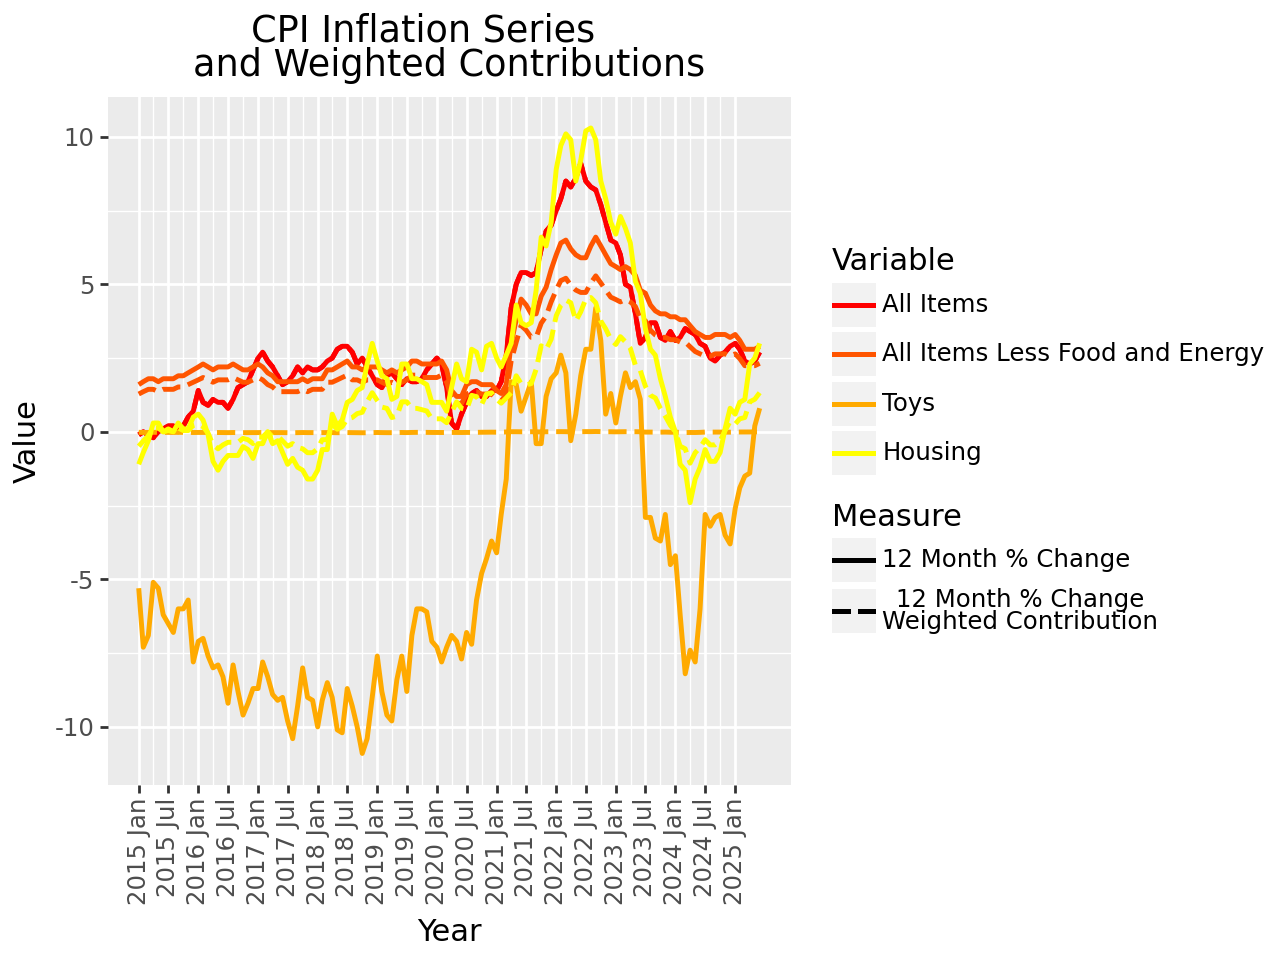

In [24]:
# Create the plot with both individual and weighted contributions
plot = (
    # Set up the plot with aesthetics: x, y, color, linetype
    ggplot(long_df, aes(x='date', y='level', color='series_id', linetype='variable')) +
    
    # Draw lines for each series and variable type
    geom_line(size=1) +
    
    # Manually set colors for each series
    scale_color_manual(values=color_map, labels=series_name_map) +
    
    # Set plot and axis labels
    labs(
        title='     CPI Inflation Series\nand Weighted Contributions',
        x='Year',
        y='Value',
        color='Variable',
        linetype='Variable'
    ) +
    
    # Manually set linetypes for the two variable types
    scale_linetype_manual(
        name="Measure",
        values=linetype_mapping,
        labels=['12 Month % Change', '12 Month % Change\nWeighted Contribution']
    ) +
    
    # Set custom x-axis ticks and labels
    scale_x_date(breaks=yq_breaks, labels=yq_labels) +
    
    # Theme adjustments: rotate x labels, set legend position, center title
    theme(
        axis_text_x=element_text(rotation=90, ha='center'),
        legend_position='right',
        plot_title=element_text(ha='center')  # Center the plot title
    ) +
    
    # Optionally remove linetype legend if desired
    guides(linetype=None)
)

display(plot)